# Documentation
* Resolution = 1.8
* aggregated sim matrix with 0.5 itp
* leiden clustering
* final avg times [2,4,6,8,10,12]
* seed = 42

# Import

In [1]:
import numpy as np
import json
from scipy.sparse import load_npz,save_npz,diags,csr_matrix
import scipy.sparse as sp
import pandas as pd
import os
from io import BytesIO
from tqdm import tqdm
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pathlib import Path
import igraph as ig
import leidenalg as la
from matplotlib.backends.backend_pdf import PdfPages
from pypdf import PdfReader, PdfWriter
from tempfile import NamedTemporaryFile
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import community as community_louvain
import pickle
from collections import defaultdict
import gc
from pympler import muppy, asizeof
from sklearn.metrics import adjusted_rand_score
import sys

# Building Multilayer Transition Matrix

In [2]:
# Choose the disease to analyze
DISEASE = "SCHIZOPHRENIA"

In [3]:
# Load all the matrices needed
OUTPUT_DIRECTORY = f"../output/{DISEASE}/"
DGIDB_DIRECTORY = f"../../Gen_Hypergraph/output/DGIDB_{DISEASE}/"
MSIGDB_DIRECTORY = "../../Gen_Hypergraph/output/MSigDB_Full/"

## DGIDB
DGIDB_binary_matrix = load_npz(DGIDB_DIRECTORY + "hypergraph_incidence_matrix_binary.npz")
DGIDB_weighted_matrix = load_npz(DGIDB_DIRECTORY + "hypergraph_incidence_matrix_weighted.npz")
DGIDB_gene_weight_diag_matrix = load_npz(DGIDB_DIRECTORY + "diag_gene_weight_matrix.npz")
DGIDB_diag_node_degree_matrix = load_npz(DGIDB_DIRECTORY + "diag_node_degree_matrix.npz")
DGIDB_inverse_diag_edge_degree_matrix = load_npz(
    DGIDB_DIRECTORY + "inverse_diag_edge_degree_matrix.npz"
    )

## MSIGDB
MSIGDB_binary_matrix = load_npz(MSIGDB_DIRECTORY + "hypergraph_incidence_matrix_binary.npz")
MSIGDB_weighted_matrix = load_npz(MSIGDB_DIRECTORY + "hypergraph_incidence_matrix_weighted.npz")
MSIGDB_gene_weight_diag_matrix = load_npz(MSIGDB_DIRECTORY + "gene_weight_diag_matrix.npz")
MSIGDB_diag_node_degree_matrix = load_npz(MSIGDB_DIRECTORY + "diag_node_degree_matrix.npz")
MSIGDB_inverse_diag_edge_degree_matrix = load_npz(
    MSIGDB_DIRECTORY + "inverse_diag_edge_degree_matrix.npz"
    )

In [4]:
DGIDB_gene_weight_diag_matrix.shape

(249, 249)

In [5]:
# queue = [[i] for i in range(1,25)]
# resolution = 1.0
# for T in queue:
#     path = f"../output/{DISEASE}/diffusion_dist_matrices/ddm_{T}_res-{resolution}.npy"
#     arr = np.load(path)
#     arr = arr.astype(np.float32)
#     np.save(path, arr)
#     print(f"Overwritten (float32): {path}")

In [6]:
# Useful Functions
def csr_equal_tol(A, B, atol=1e-8):
    # First check shapes and sparsity pattern
    if A.shape != B.shape or not np.array_equal(A.indptr, B.indptr) or not np.array_equal(A.indices, B.indices):
        return False
    # Compare numeric values within tolerance
    return np.allclose(A.data, B.data, atol=atol, rtol=0)

def is_symmetric(W,tol = 1e-8):
    diff = (W - W.T)
    check = np.all(np.abs(diff.data) < tol)
    return check

def degree_array(W, a=1):
    return np.asarray(W.sum(axis=a)).ravel()

def degree_diagonal_matrix(W, a=1):
    d = degree_array(W,a)
    return sp.diags(d, offsets=0, format='csr')

def symmetrically_normalize(W, a=1):
    D = np.asarray(W.sum(axis=a)).ravel()
    D_inv_sqrt = np.zeros_like(D)
    nze = D != 0
    D_inv_sqrt[nze] = 1 / np.sqrt(D[nze])

    W_sym = W.multiply(D_inv_sqrt)              # scale columns
    W_sym = W_sym.multiply(D_inv_sqrt[:, None]) # scale rows    
    return W_sym.tocsr()

def big_objects(n=10, min_mb=1):
    """
    Show the largest objects currently in memory.
    
    Parameters
    ----------
    n : int
        Number of top objects to show.
    min_mb : float
        Minimum size (in MB) to include.
    """
    import sys
    import numpy as np
    import pandas as pd
    import scipy.sparse as sp
    from IPython import get_ipython

    def get_size(obj):
        try:
            if isinstance(obj, np.ndarray):
                return obj.nbytes
            elif isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
                return obj.memory_usage(deep=True).sum()
            elif sp.issparse(obj):
                return (obj.data.nbytes +
                        obj.indptr.nbytes +
                        obj.indices.nbytes)
            else:
                return sys.getsizeof(obj)
        except Exception:
            return 0

    ip = get_ipython()
    if ip is None:
        ns = globals()
    else:
        ns = ip.user_ns

    items = []
    for name, val in ns.items():
        if name.startswith('_'):
            continue  # skip internals
        size = get_size(val)
        if size > min_mb * 1024 ** 2:
            items.append((name, type(val).__name__, size))

    items.sort(key=lambda x: x[2], reverse=True)

    print(f"{'Variable':30s} {'Type':25s} {'Size (MB)':>10s}")
    print("-" * 70)
    for name, t, size in items[:n]:
        print(f"{name:30s} {t:25s} {size / 1024 ** 2:10.2f}")

In [7]:
# Building Adjacency Matrices
## DGIDB
H,W_v,D_v,D_e_inv = DGIDB_weighted_matrix, DGIDB_gene_weight_diag_matrix, DGIDB_diag_node_degree_matrix, DGIDB_inverse_diag_edge_degree_matrix

# Construct D_v^(-1/2)
d = (D_v @ W_v).diagonal()
d_inv_sqrt = np.zeros_like(d)
nonzero_mask = d > 0
d_inv_sqrt[nonzero_mask] = 1.0 / np.sqrt(d[nonzero_mask])
D_v_sqrt_inv = diags(d_inv_sqrt)

DGIDB_adjacency_matrix = D_v_sqrt_inv @ H @ D_e_inv @ H.T @ D_v_sqrt_inv


## MSIGDB
H,W_v,D_v,D_e_inv = MSIGDB_weighted_matrix, MSIGDB_gene_weight_diag_matrix, MSIGDB_diag_node_degree_matrix, MSIGDB_inverse_diag_edge_degree_matrix

# Construct D_v^(-1/2)
d = (D_v @ W_v).diagonal()
d_inv_sqrt = np.zeros_like(d)
nonzero_mask = d > 0
d_inv_sqrt[nonzero_mask] = 1.0 / np.sqrt(d[nonzero_mask])
D_v_sqrt_inv = diags(d_inv_sqrt)

MSIGDB_adjacency_matrix = D_v_sqrt_inv @ H @ D_e_inv @ H.T @ D_v_sqrt_inv

# Compute Degree Diagonal Matrices
DGIDB_rows_sums = degree_array(DGIDB_adjacency_matrix)
MSIGDB_rows_sums = degree_array(MSIGDB_adjacency_matrix)

In [8]:
print(is_symmetric(DGIDB_adjacency_matrix,tol=1e-7))
print(is_symmetric(MSIGDB_adjacency_matrix))

True
True


In [9]:
# Symmetric Normalization
DGIDB_adjacency_matrix = symmetrically_normalize(DGIDB_adjacency_matrix)
MSIGDB_adjacency_matrix = symmetrically_normalize(MSIGDB_adjacency_matrix)

In [10]:
print(DGIDB_adjacency_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 22793 stored elements and shape (249, 249)>
  Coords	Values
  (0, 0)	0.0002815042098518461
  (0, 1)	0.0009815060766413808
  (0, 2)	0.0017762435600161552
  (0, 3)	0.0016535983886569738
  (0, 4)	0.0008341943612322211
  (0, 5)	0.0017884676344692707
  (0, 6)	0.0016295115929096937
  (0, 7)	8.163123857229948e-05
  (0, 8)	0.0013448529643937945
  (0, 9)	0.0015506407944485545
  (0, 10)	5.836625859956257e-05
  (0, 11)	0.0010933735175058246
  (0, 12)	0.0011928911553695798
  (0, 13)	0.0017913264455273747
  (0, 14)	0.0003182952059432864
  (0, 15)	0.00023077393416315317
  (0, 16)	0.0005499623366631567
  (0, 17)	0.0003986138035543263
  (0, 18)	0.0001846546947490424
  (0, 19)	6.9795387389604e-05
  (0, 20)	0.0011275901924818754
  (0, 21)	0.0001059973074006848
  (0, 22)	0.001285185688175261
  (0, 23)	8.993041410576552e-05
  (0, 24)	0.0017610486829653382
  :	:
  (248, 134)	0.02656160295009613
  (248, 139)	0.013731636106967926
  (248, 143)	0.00

In [11]:
print(is_symmetric(DGIDB_adjacency_matrix,tol=1e-7))
print(is_symmetric(MSIGDB_adjacency_matrix))

True
True


In [12]:
# density = DGIDB_adjacency_matrix.nnz / (DGIDB_adjacency_matrix.shape[0] * DGIDB_adjacency_matrix.shape[1])
# print("DGIDB Density:", density)
# density = MSIGDB_adjacency_matrix.nnz / (MSIGDB_adjacency_matrix.shape[0] * MSIGDB_adjacency_matrix.shape[1])
# print("MSIGDB Density:", density)

In [13]:
# Check nonzero average
DGIDB_nonzero_average = DGIDB_adjacency_matrix[DGIDB_adjacency_matrix != 0].mean()
MSIGDB_nonzero_average = MSIGDB_adjacency_matrix[MSIGDB_adjacency_matrix != 0].mean()

print("DGIDB nonzero average:",DGIDB_nonzero_average,"\nMSIGDB nonzero average:",MSIGDB_nonzero_average)

DGIDB nonzero average: 0.007738274 
MSIGDB nonzero average: 9.87564623806718e-05


In [14]:
# # Density normalization version 1
# target_average = MSIGDB_nonzero_average
# DGIDB_adjacency_matrix = (target_average / DGIDB_nonzero_average) * DGIDB_adjacency_matrix
# MSIGDB_adjacency_matrix = (target_average / MSIGDB_nonzero_average) * MSIGDB_adjacency_matrix

# DGIDB_nonzero_average = DGIDB_adjacency_matrix[DGIDB_adjacency_matrix != 0].mean()
# MSIGDB_nonzero_average = MSIGDB_adjacency_matrix[MSIGDB_adjacency_matrix != 0].mean()

# print(DGIDB_nonzero_average,MSIGDB_nonzero_average)

In [15]:
# Density normalization version 2
DGIDB_mean_degree = DGIDB_rows_sums[DGIDB_rows_sums != 0].mean()
MSIGDB_mean_degree = MSIGDB_rows_sums[MSIGDB_rows_sums != 0].mean()
print(DGIDB_mean_degree,MSIGDB_mean_degree)
# print(DGIDB_rows_sums,MSIGDB_rows_sums)

DGIDB_weight = (1/DGIDB_mean_degree) / ((1/DGIDB_mean_degree)+(1/MSIGDB_mean_degree))
MSIGDB_weight = (1/MSIGDB_mean_degree) / ((1/DGIDB_mean_degree)+(1/MSIGDB_mean_degree))
geo_mean_weight = (DGIDB_weight * MSIGDB_weight)**(1/2)
print(DGIDB_weight,MSIGDB_weight)
print(geo_mean_weight)

0.49658772 0.2379564756116163
0.32395120116868437 0.6760487988313156
0.46798164539867476


In [16]:
## Build interlayer coupling matrices between the two layers

# Open the JSON file and load its content into a dictionary
with open(DGIDB_DIRECTORY + f"gene_to_index.json", "r") as file:
    DGIDB_gene_to_index = json.load(file)
with open(MSIGDB_DIRECTORY + "gene_to_index.json", "r") as file:
    MSIGDB_gene_to_index = json.load(file)

DGIDB_index_to_gene = {index: gene for gene, index in DGIDB_gene_to_index.items()}   
# Jump probability for matching genes
w = 1

# Number of genes (assuming they are both of same size or matchable)
num_genes_dgidb = len(DGIDB_gene_to_index)
num_genes_msigdb = len(MSIGDB_gene_to_index)

# Initialize the inter-layer matrix with zeros
interlayer_transition_matrix = np.zeros((num_genes_msigdb,num_genes_dgidb))
i = 0
# Build the inter-layer matrix
for gene_dgidb, idx_dgidb in DGIDB_gene_to_index.items():
    # If the gene exists in both gene-to-index mappings
    if gene_dgidb in MSIGDB_gene_to_index:      
        idx_msigdb = MSIGDB_gene_to_index[gene_dgidb]
        interlayer_transition_matrix[idx_msigdb,idx_dgidb] = w  # Set jump probability
        i += 1
    else:
        print(f"Gene {gene_dgidb} not found in MSIGDB mapping.")
rows_with_high_sum = np.where(interlayer_transition_matrix.sum(axis=1) > 0)[0]
print(i/len(DGIDB_gene_to_index), "of DGIDB genes have a match in MSIGDB")

interlayer_transition_matrix = interlayer_transition_matrix.astype(np.float32)

Gene 11 not found in MSIGDB mapping.
Gene 100302144 not found in MSIGDB mapping.
Gene 100302251 not found in MSIGDB mapping.
Gene 652991 not found in MSIGDB mapping.
Gene 386607 not found in MSIGDB mapping.
Gene 267012 not found in MSIGDB mapping.
Gene 693167 not found in MSIGDB mapping.
0.9718875502008032 of DGIDB genes have a match in MSIGDB


In [17]:
print(interlayer_transition_matrix.shape)
print(len(DGIDB_gene_to_index))

(21981, 249)
249


In [18]:
# # Check for Row-stochastic
# row_sums = np.array(DGIDB_adjacency_matrix.sum(axis=1)).ravel()
# print(row_sums)
# ok = np.all(np.isclose(row_sums, 1.0)|np.isclose(row_sums, 0))
# print("Every row sums to 0 or 1?", ok)

# row_sums = np.array(MSIGDB_adjacency_matrix.sum(axis=1)).ravel()
# print(row_sums)
# ok = np.all(np.isclose(row_sums, 1.0)|np.isclose(row_sums, 0))
# print("Every row sums to 0 or 1?", ok)

In [19]:
## Build the multilayer transition matrix
# interlayer_transition_prob = target_average
interlayer_transition_prob = 0.5

A = (1-interlayer_transition_prob) * DGIDB_weight * DGIDB_adjacency_matrix
B = interlayer_transition_prob * geo_mean_weight * interlayer_transition_matrix.T
C = interlayer_transition_prob * geo_mean_weight * interlayer_transition_matrix
D =(1-interlayer_transition_prob) * MSIGDB_weight * MSIGDB_adjacency_matrix

multilayer_transition_matrix = sp.bmat([
    [A, B],
    [C, D]
]).tocsr()

num_genes = multilayer_transition_matrix.shape[0]

multilayer_transition_matrix = multilayer_transition_matrix.astype(np.float32)

del A,B,C,D, DGIDB_adjacency_matrix,MSIGDB_adjacency_matrix
gc.collect()

48

In [20]:
density = multilayer_transition_matrix.nnz / (multilayer_transition_matrix.shape[0] * multilayer_transition_matrix.shape[1])
print("MTM Density:", density)

MTM Density: 0.21706022325384497


In [21]:
MTM_average = multilayer_transition_matrix[multilayer_transition_matrix != 0].mean()
print("MTM nonzero average:",MTM_average)

MTM nonzero average: 3.4697106e-05


# Computing Eigenvalues & Eigenvectors

In [22]:
num_eigenvalues = 100

In [23]:
# Compute top k eigenvalues by magnitude
def top_k_eigenvalues(M,k):
    vals, vecs = eigsh(M, k=k, which='LM')  # 'LM' = Largest Magnitude
    idx = np.argsort(np.abs(vals))[::-1]
    vals, vecs = vals[idx], vecs[:, idx]
    return vals, vecs

In [24]:
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = top_k_eigenvalues(multilayer_transition_matrix,num_eigenvalues)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors shape:", eigenvectors.shape)

Eigenvalues: [0.36888996 0.3313712  0.3215911  0.31512135 0.3077419  0.29981205
 0.29880303 0.2983647  0.29608154 0.2937071  0.29131088 0.2898346
 0.28445435 0.28157714 0.27899852 0.2758521  0.27378348 0.2679009
 0.2580739  0.2545951  0.25366282 0.2526557  0.25211588 0.25184685
 0.25042167 0.25032762 0.24972148 0.24920298 0.24778292 0.2467903
 0.2460647  0.24546012 0.24471131 0.24436475 0.24407399 0.24350029
 0.2432776  0.2430293  0.24254623 0.242435   0.24230422 0.24219894
 0.24210274 0.24188104 0.24147855 0.24141051 0.2411915  0.24112417
 0.24099794 0.24094835 0.24088189 0.24064232 0.24059838 0.24046801
 0.24040928 0.24031344 0.24028893 0.2402143  0.24019372 0.24010658
 0.2400596  0.24003373 0.2398949  0.23983176 0.23979923 0.23970526
 0.23967367 0.23959634 0.23953806 0.23947957 0.23938628 0.23930809
 0.23925018 0.2392246  0.23904195 0.2390193  0.23881583 0.23875892
 0.23864967 0.23863606 0.2385697  0.23849295 0.23846841 0.23844743
 0.23840907 0.23832814 0.23828104 0.23824097 0.23818

# KNN Graph Methods

In [26]:
def stationary_distribution(W, tol=1e-12, maxit=10000):
    # power iteration for left stationary of row-stochastic W
    n = W.shape[0]
    pi = np.ones(n) / n
    for _ in range(maxit):
        pi_next = pi @ W
        if np.linalg.norm(pi_next - pi, 1) < tol:
            break
        pi = pi_next
    return pi / pi.sum()

def layer_weights_stationary(W, n):
    pi = stationary_distribution(W)
    w1 = float(pi[:n].sum()); w2 = 1.0 - w1
    return w1, w2

In [27]:
w1,w2 = layer_weights_stationary(multilayer_transition_matrix, num_genes_dgidb)

In [28]:
print(w1,w2)

0.09745131298826905 0.902548687011731


In [29]:
# Build diffusion matrix from eigenvalues and eigenvectors (double check)
def build_diffusion_dist_matrix(vals,vecs,t):
    X_t = vecs * (vals ** (t))
    D_t2 = squareform(pdist(X_t, metric='sqeuclidean'))
    D_t2 = D_t2.astype(np.float32)
    return D_t2

def build_diffusion_dist_matrix_avg(vals,vecs,T):
    diffusion_dist_matrix = np.zeros((num_genes,num_genes))
    for t in T:
        np.add(diffusion_dist_matrix, 
            build_diffusion_dist_matrix(vals,vecs,t), 
            out=diffusion_dist_matrix)
    diffusion_dist_matrix = diffusion_dist_matrix / len(T)
    return diffusion_dist_matrix

In [61]:
def build_kNN(diffusion_dist_matrix,k, sym_method='average'):
    # Choose sigma to be the median of pair-wise distance
    tmp = diffusion_dist_matrix.astype(np.float32, copy=True)
    np.sqrt(tmp, out=tmp)
    sigma = np.median(tmp[tmp != 0], overwrite_input=True)

    n = diffusion_dist_matrix.shape[0]
    
    print(sigma)

    # Used to indicate position of nonzero value needed to record (constructing a sparse matrix for efficiency)
    rows, cols, vals = [], [], []
    for i in range(n):
        profile = np.exp(-diffusion_dist_matrix[i] / (2* (sigma**2))) 
        idx = np.argpartition(-profile, k+1)[:k+1]  # top-k+1 (includes self)
        idx = idx[idx != i]                      # drop self
        rows += [i]*k
        cols += list(idx[:k])
        vals += list(profile[idx[:k]])
    adj_mat = csr_matrix((vals, (rows, cols)), shape=(n, n))

    # Symmetrize the matrix by adding edges to one way edges and set weight to average
    if (sym_method == 'average'):
        adj_mat = (adj_mat + adj_mat.T).multiply(0.5).tocsr()

    # Symmetrize the matrix by unioning
    elif (sym_method == 'union'):
        adj_mat = adj_mat.maximum(adj_mat.T)
    elif (sym_method == 'none'):
        pass
    else:
        raise ValueError("sym_method must be 'average' or 'union'")

    
    return adj_mat, sigma



In [30]:
def relabel_dgidb_then_msigdb(A, dgidb_idx, msigdb_idx):
    """
    A: square sparse matrix (any format)
    dgidb_idx: 1D array of old indices that are DGIDB
    msigdb_idx: 1D array of old indices that are MSIGDB

    New order:
      [all DGIDB indices in dgidb_idx order] +
      [all MSIGDB indices in msigdb_idx order]

    Returns:
      A_new: matrix with new index order
      old_to_new: array mapping old_index -> new_index
    """

    # 1. Build permutation (old indices in desired new order)
    perm = np.concatenate([dgidb_idx, msigdb_idx])  # length = num_dgidb + num_msigdb

    # 2. Build old -> new mapping
    max_idx = perm.max()
    old_to_new = -np.ones(max_idx + 1, dtype=int)
    old_to_new[perm] = np.arange(len(perm))

    # 3. Apply permutation on rows and columns
    A = A.tocoo()
    new_rows = old_to_new[A.row]
    new_cols = old_to_new[A.col]

    A_new = sp.csr_matrix((A.data, (new_rows, new_cols)),
                          shape=(len(perm), len(perm)))
    A_new.eliminate_zeros()

    return A_new

In [31]:
def aggregate(M, 
              n1 = num_genes_dgidb,
              n2 = num_genes_msigdb):
    N = n1 + n2
    
    # Calculate w1,w2
    w1,w2 = layer_weights_stationary(multilayer_transition_matrix, num_genes_dgidb)
    
    # build DGIDB_to_real
    dgidb_to_real = []
    dgidb_idx = []
    gene_to_index_dgidb_new= {}
    coupling_matrix = interlayer_transition_matrix.T
    num_additional_rows = 0
    index = 0
    for row in coupling_matrix:
        if(np.all(row == 0)):
            dgidb_to_real.append(index)
            dgidb_idx.append(index) 
            gene_to_index_dgidb_new[DGIDB_index_to_gene[index]] = num_additional_rows
            num_additional_rows += 1
        else:
            l = np.nonzero(row)[0]
            if (len(l) > 1):
                print("ERROR")
            else:
                msigdb_pos = l[0]
                dgidb_to_real.append(n1 + msigdb_pos)
        index += 1
    msigdb_idx = np.arange(n1,n1+n2)
        
    MSIGDB_gene_to_index_new = {g: i + num_additional_rows for g, i in MSIGDB_gene_to_index.items()}
    gene_to_index_distinct = MSIGDB_gene_to_index_new | gene_to_index_dgidb_new
    
    # print(f"{set(MSIGDB_gene_to_index_new.keys()) & set(gene_to_index_dgidb_new.keys())} == 0?")
    # print(f"{set(MSIGDB_gene_to_index_new.values()) & set(gene_to_index_dgidb_new.values())} == 0?")
    # print(num_additional_rows,len(dgidb_idx))
    
    save_path = OUTPUT_DIRECTORY + "gene_to_index_distinct.json"
    with open(save_path, 'w') as pathway_file:
        json.dump(gene_to_index_distinct, pathway_file, indent=4)
    print(f"Mappings saved to {save_path}")    
        
    # Build full mapping for 0..N-1
    # DGIDB indices: use dgidb_to_real
    # MSIGDB indices: they map to themselves
    map_full = np.empty(N, dtype=np.int64)
    map_full[:n1] = dgidb_to_real                # unmapped DGIDB keeps i; mapped DGIDB gets MSIGDB index
    map_full[n1:] = np.arange(n2) + n1           # MSIGDB stays as itself

    # --- STEP 1: Extract all nonzero entries
    if isinstance(M, np.ndarray):
        # Dense: extract nonzero entries via numpy only
        rows, cols = np.nonzero(M)
        vals = M[rows, cols]

    elif sp.issparse(M):
        # Sparse: convert to COO and extract entries
        Scoo = M.tocoo()
        rows = Scoo.row
        cols = Scoo.col
        vals = Scoo.data

    else:
        raise TypeError("M must be a NumPy ndarray or a SciPy sparse matrix.")

    # --- STEP 3: Group all contributions by their final coordinate
    # We'll use a dictionary[(u,v)] = list of (value, is_original_boolean)
    buckets = {}

    for (i, j, v) in zip(rows, cols, vals):
        u = map_full[i]
        w = map_full[j]

        moved = not (u == i and w == j)
        is_original = (not moved)

        buckets.setdefault((u, w), []).append((v, is_original))

    # --- STEP 4: Aggregate according to the rule
    final_rows = []
    final_cols = []
    final_vals = []

    for (u, w), entries in buckets.items():

        # Separate originals and additionals
        originals   = [v for (v, orig) in entries if orig]
        additionals = [v for (v, orig) in entries if not orig]

        if len(originals) == 0:
            # If NOTHING is original → define original as 0
            # print("NOTHING IS ORIGINAL",len(additionals))
            w_orig = 0
        else:
            # Should normally be 1, but take the first if multiple
            w_orig = originals[0]

        if len(additionals) == 0:
            # No additional contributions → keep original
            W = w_orig
        else:
            S_add = sum(additionals)
            W = w1 * w_orig + w2 * S_add

        final_rows.append(u)
        final_cols.append(w)
        final_vals.append(W)

    # --- STEP 5: Build sparse matrix
    # Matrix dimension: max index + 1
    Mdim = max(max(final_rows), max(final_cols)) + 1
    A = sp.csr_matrix((final_vals, (final_rows, final_cols)), shape=(Mdim, Mdim))
    A.setdiag(0)
    A.eliminate_zeros()
    
    # Condense the matrix
    A = relabel_dgidb_then_msigdb(A,dgidb_idx,msigdb_idx)
    
    return A

In [32]:
def knn_symmetric(adj_mat,sym_method='average'):
    if (sym_method == 'average'):
        adj_mat = (adj_mat + adj_mat.T).multiply(0.5).tocsr()
    # Symmetrize the matrix by unioning
    elif (sym_method == 'union'):
        adj_mat = adj_mat.maximum(adj_mat.T)
    else:
        raise ValueError("sym_method must be 'average' or 'union'")

    return adj_mat

In [33]:
# def knn_filter(D, k):
#     n = D.shape[0]

#     rows = np.repeat(np.arange(n), k)
#     cols = np.empty(n * k, dtype=np.int64)
#     vals = np.empty(n * k, dtype=D.dtype)

#     pos = 0
#     for i in range(n):
#         row = D[i].copy()
#         row[i] = np.inf
#         nn_idx = np.argpartition(row, k)[:k]

#         cols[pos:pos+k] = nn_idx
#         vals[pos:pos+k] = row[nn_idx]
#         pos += k

#     return csr_matrix((vals, (rows, cols)), shape=(n, n))


In [34]:
# def diffusion_to_gaussian_similarity(D_csr, sigma=None, copy=True):
#     """
#     Convert a diffusion distance matrix in CSR format to a Gaussian kernel
#     similarity matrix, keeping the same sparsity pattern.

#     Parameters
#     ----------
#     D_csr : csr_matrix
#         Sparse diffusion distance matrix (only nonzeros are stored).
#     sigma : float or None
#         Bandwidth of the Gaussian kernel. If None, use median of nonzero distances.
#     copy : bool
#         If True, do not modify D_csr in-place; return a new matrix.
#         If False, transform D_csr.data in-place.

#     Returns
#     -------
#     S_csr : csr_matrix
#         Sparse similarity matrix with same sparsity pattern as D_csr.
#     """
#     if not isinstance(D_csr, csr_matrix):
#         raise TypeError("D_csr must be a scipy.sparse.csr_matrix")

#     S = D_csr.copy() if copy else D_csr

#     # Nonzero distances
#     d = S.data.astype(np.float64, copy=False)

#     if sigma is None:
#         # Use median of nonzero distances as a simple default
#         sigma = np.median(d)
        
#     print(sigma)

#     # Gaussian kernel on the nonzeros
#     S.data = np.exp(-d / (2.0 * sigma**2))

#     return S


# # def build_aggregated_kNN(
# #     ddm,                
# #     num_neighbors,
# #     sym_method='average'):

# #     ddm_filtered = knn_filter(ddm, k = num_neighbors)
# #     ddm_agg = aggregate(ddm_filtered)
# #     sim_mat = diffusion_to_gaussian_similarity(ddm_agg)
# #     sim_mat = knn_symmetric(sim_mat, sym_method=sym_method)
    
# #     graph = nx.from_scipy_sparse_array(sim_mat)
    
# #     return sim_mat, graph, ddm_agg


In [58]:
def build_aggregated_kNN(
    ddm,                
    num_neighbors,
    sym_method='average'):

    sim_mat,sigma = build_kNN(ddm, k = num_neighbors, sym_method="none")
    sim_mat = aggregate(sim_mat)
    sim_mat_sym = knn_symmetric(sim_mat, sym_method=sym_method)
        
    graph = nx.from_scipy_sparse_array(sim_mat_sym)
    
    return sim_mat_sym, graph, sigma
    


In [37]:
print(num_genes_dgidb+num_genes_msigdb)

22230


In [38]:
print(3+num_genes_msigdb)

21984


# Clustering Methods

In [39]:
# # Louvain
# def louvain_from_adj(A, resolution=1.0, random_state=0, keep_lcc=False):
#     """
#     A: symmetric, non-negative scipy.sparse adjacency (CSR preferred).
#     Returns: labels (np.ndarray of length n), graph G (NetworkX), node_order
#     """
#     # if not sp.isspmatrix(A):  # allow dense but convert
#     #     A = sp.csr_matrix(A)
#     # # Optional: ensure symmetry numerically
#     # if (A - A.T).nnz != 0:
#     #     raise ValueError("Adjacency must be symmetric. Symmetrize first.")

#     # Build graph
#     # networkx >=3.0: from_scipy_sparse_array; older: from_scipy_sparse_matrix
#     G = nx.from_scipy_sparse_array(A, edge_attribute='weight')  # undirected by default

#     if keep_lcc:
#         # keep only the largest connected component if you prefer
#         largest_cc = max(nx.connected_components(G), key=len)
#         G = G.subgraph(largest_cc).copy()

#     # Run Louvain
#     part = community_louvain.best_partition(
#         G, weight='weight', resolution=resolution, random_state=random_state
#     )
#     node_order = sorted(G.nodes())
#     labels = np.array([part[i] for i in node_order], dtype=int)
#     return labels, G, node_order

# def DDBC(MTM,num_eigenvalues,num_neighbors,resolution,T):
#     vals,vecs = top_k_eigenvalues(M = MTM, k = num_eigenvalues)

#     diffusion_dist_matrix = np.zeros((num_genes,num_genes))
#     for t in T:
#         np.add(diffusion_dist_matrix, 
#                build_diffusion_dist_matrix(vals,vecs,t,num_eigenvalues), 
#                out=diffusion_dist_matrix)
#     diffusion_dist_matrix = diffusion_dist_matrix / len(T)
    
#     kNN_adjacency_matrix = build_kNN(diffusion_dist_matrix,num_neighbors)

#     # # Symmetrize the matrix by adding edges to one way edges and set weight to average
#     # kNN_adjacency_matrix = (kNN_adjacency_matrix + kNN_adjacency_matrix.T).multiply(0.5).tocsr()

#     # Symmetrize the matrix by unioning
#     kNN_adjacency_matrix = kNN_adjacency_matrix.maximum(kNN_adjacency_matrix.T)

#     return louvain_from_adj(kNN_adjacency_matrix, resolution = resolution, keep_lcc = False) 

In [40]:
def leiden_from_knn_adjacency(
    A,
    *,
    method="modularity",      # "modularity" | "rb" | "cpm"
    resolution=1.0,           # used by "rb" and "cpm"
    n_iterations=-1,          # -1 => until no improvement
    seed=42,
    use_weights=True
):
    """
    Run Leiden on a symmetric, undirected (weighted) kNN adjacency (SciPy sparse).

    Returns
    -------
    labels : np.ndarray[int]
        Community ID per node (0..k-1)
    quality : float
        Objective value (modularity / RB / CPM depending on 'method')
    """
    if not sp.issparse(A):
        raise TypeError("A must be a SciPy sparse matrix.")
    # Normalize format & dtype
    A = A.tocsr().astype(np.float32, copy=False)

    # Clean diagonal and robustly symmetrize
    A.setdiag(0.0)
    A.eliminate_zeros()
    A = A.maximum(A.T)  # keep max weight per undirected edge

    # Build igraph from upper triangle (each undirected edge once)
    U = sp.triu(A, k=1, format="coo")
    n = A.shape[0]
    g = ig.Graph(n=n, edges=list(zip(U.row.tolist(), U.col.tolist())), directed=False)
    wname = None
    if use_weights:
        g.es["weight"] = U.data.tolist()
        wname = "weight"

    # Pick partition class + kwargs
    m = method.lower()
    if m == "modularity":
        part_cls = la.ModularityVertexPartition
        kwargs = dict(weights=wname)
    elif m == "rb":
        part_cls = la.RBConfigurationVertexPartition
        kwargs = dict(weights=wname, resolution_parameter=resolution)
    elif m == "cpm":
        part_cls = la.CPMVertexPartition
        kwargs = dict(weights=wname, resolution_parameter=resolution)
    else:
        raise ValueError("method must be 'modularity', 'rb', or 'cpm'")

    # Run Leiden
    part = la.find_partition(
        g,
        part_cls,
        n_iterations=n_iterations,
        seed=seed,
        **kwargs
    )

    labels = np.array(part.membership, dtype=np.int32)
    communities = [list(c) for c in part]
    return labels, float(part.quality()), communities

In [41]:
def DDBC(vals,
         vecs,
         num_neighbors,
         resolution,
         T,
         leiden_method = "modularity",
         ddm = None):
    output_folder = f"../output/{DISEASE}/diffusion_dist_matrices"
    os.makedirs(output_folder, exist_ok=True)
    if ddm is None:
        diffusion_dist_matrix = build_diffusion_dist_matrix_avg(vals, vecs,T)
        np.save(f"{output_folder}/ddm_{T}_res-{resolution}_itp-{interlayer_transition_prob}.npy",diffusion_dist_matrix)
    else:
        diffusion_dist_matrix = ddm
    
    kNN_adjacency_matrix, kNN_graph, sigma = build_aggregated_kNN(diffusion_dist_matrix,num_neighbors)
    save_npz(f"{OUTPUT_DIRECTORY}/agg_sim_mat.npz", kNN_adjacency_matrix)

    return (*leiden_from_knn_adjacency(kNN_adjacency_matrix,method=leiden_method,resolution=resolution,n_iterations=-1,seed=42), kNN_graph, kNN_adjacency_matrix,sigma)

In [42]:
def community_report_onepage(labels, score, out_pdf="leiden_community_report.pdf", *,
                             extra_text=None, bins="auto", title="Community Sizes", time_steps = "N/A"):
    """
    Create ONE PDF page (top: text summary, bottom: histogram).
    If out_pdf exists: append this page. Else: create it.

    Requires: matplotlib, pypdf  (pip install pypdf)
    """
    # ---- inputs ----
    labels = np.asarray(labels)
    if labels.ndim != 1:
        raise ValueError("labels must be a 1-D array of community ids")

    # ---- stats ----
    sizes = np.bincount(labels.astype(np.int64, copy=False))
    sizes_sorted = np.sort(sizes)
    n, k = sizes.sum(), sizes.size

    lines = [
        "Leiden Partition Summary",
        "========================",
        f"Nodes (n):           {n:,}",
        f"Time steps:          {time_steps}",
        f"Communities (k):     {k:,}",
        f"Size (min):          {int(sizes_sorted[0]) if k else 0:,}",
        f"Size (median):       {float(np.median(sizes_sorted)) if k else 0.0:.3f}",
        f"Size (mean):         {float(sizes_sorted.mean()) if k else 0.0:.6f}",
        f"Size (max):          {int(sizes_sorted[-1]) if k else 0:,}",
        f"Score:               {score}",
        "",
        "Top 10 largest communities (id: size):",
    ]
    for cid in np.argsort(-sizes)[:min(10, k)]:
        lines.append(f"  {int(cid):5d}: {int(sizes[cid]):,}")
    if extra_text:
        lines += ["", "Extra:", *([extra_text] if isinstance(extra_text, str) else list(extra_text))]
    summary_text = "\n".join(lines)

    # ---- draw single-page figure ----
    fig = plt.figure(figsize=(8.5, 11), dpi=150)          # US Letter, higher DPI
    ax_text = fig.add_axes([0.06, 0.55, 0.88, 0.40])      # [left, bottom, width, height]
    ax_text.axis("off")
    ax_text.text(0.0, 1.0, summary_text, va="top", ha="left", fontsize=11, family="monospace")

    ax_hist = fig.add_axes([0.10, 0.08, 0.80, 0.38])
    ax_hist.hist(sizes, bins=bins)
    ax_hist.set_xlabel("Community size")
    ax_hist.set_ylabel("Count of communities")
    ax_hist.set_title(f"Distribution of {title}")

    # ---- write this page to a temp PDF on disk ----
    with NamedTemporaryFile(delete=False, suffix=".pdf") as tmpf:
        tmp_page = Path(tmpf.name)
    with PdfPages(tmp_page) as pdf:
        pdf.savefig(fig)
    plt.close(fig)

    # ---- append/create using PdfReader/PdfWriter (robust across versions) ----
    try:
        from pypdf import PdfReader, PdfWriter
    except Exception as e:
        try: os.remove(tmp_page)
        except: pass
        raise RuntimeError("Please install 'pypdf' (e.g., `pip install pypdf`).") from e

    out_pdf = Path(out_pdf)
    tmp_out = out_pdf.with_suffix(out_pdf.suffix + ".tmp")

    writer = PdfWriter()

    # if existing, copy old pages first
    if out_pdf.exists():
        with open(out_pdf, "rb") as f_exist:
            reader = PdfReader(f_exist)
            for p in reader.pages:
                writer.add_page(p)

    # add the new single page
    with open(tmp_page, "rb") as f_new:
        reader_new = PdfReader(f_new)
        for p in reader_new.pages:
            writer.add_page(p)

    # atomic write
    with open(tmp_out, "wb") as f_out:
        writer.write(f_out)
    os.replace(tmp_out, out_pdf)

    # cleanup
    try: os.remove(tmp_page)
    except: pass

    return out_pdf


# Run DDBC 1 - 24

In [ ]:
# Leiden Clustering
pdf_path = f"../output/{DISEASE}/leiden_report.pdf"
method = "modularity"
resolution = 1.3
num_neighbors = 100
num_bins = 100
write = True
queue = [[i] for i in range(1,2)]
label_list = []
score_list = []
graph_list = []
communities_list = []

In [ ]:
# # Load variables:
# DATA_DIRECTORY = OUTPUT_DIRECTORY + "leiden_result_variables_temp"
# with open(f"{DATA_DIRECTORY}/label.pkl", "rb") as f:
#     label_list = pickle.load(f)
# with open(f"{DATA_DIRECTORY}/score.pkl", "rb") as f:
#     score_list = pickle.load(f)
# with open(f"{DATA_DIRECTORY}/graph.pkl", "rb") as f:
#     graph_list = pickle.load(f)
# with open(f"{DATA_DIRECTORY}/communities.pkl", "rb") as f:
#     communities_list = pickle.load(f)

In [ ]:
for T in queue:
    labels, score, communities, graph, sim_mat, _ = DDBC(eigenvalues, eigenvectors, num_neighbors, resolution, T, leiden_method = method)
    if (write):
        path = community_report_onepage(labels, score, out_pdf=pdf_path,
                                        extra_text=[f"method={method}", f"resolution={resolution}"], 
                                        bins=num_bins,time_steps = T)
        print("Wrote:", path)
    label_list.append(labels)
    score_list.append(score) 
    graph_list.append(graph)
    communities_list.append(communities)

In [ ]:
# # Save resulting variables to save time
# DATA_DIRECTORY = OUTPUT_DIRECTORY + "leiden_result_variables_temp"
# with open(f"{DATA_DIRECTORY}/label.pkl", "wb") as f:
#     pickle.dump(label_list, f)
# with open(f"{DATA_DIRECTORY}/score.pkl", "wb") as f:
#     pickle.dump(score_list, f)
# with open(f"{DATA_DIRECTORY}/graph.pkl", "wb") as f:
#     pickle.dump(graph_list, f)
# with open(f"{DATA_DIRECTORY}/communities.pkl", "wb") as f:
#     pickle.dump(communities_list, f)

# Visualization

In [ ]:
def community_central_genes(G, community_nodes, weight="weight", top_n=20):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    mu, sigma = ks.mean(), ks.std() if ks.std() > 0 else 1.0
    Z = {u: (k[u] - mu)/sigma for u in H}          # within-module degree z-score

    # rank by z
    ranked = sorted(H.nodes(), key=lambda u: (Z[u]), reverse=True)
    return {u : Z[u] for u in ranked[:top_n]}

def weighted_jaccard(scoresA, scoresB):
    """
    Compute Weighted Jaccard similarity between two communities
    based on gene importance scores.
    
    Parameters:
        scoresA, scoresB : dict
            {gene: importance_score}
            Scores can be any nonnegative values (e.g., PageRank, Z-score).
    Returns:
        float
            Weighted Jaccard similarity in [0, 1].
    """
    genes = set(scoresA) | set(scoresB)
    if not genes:
        return 0.0
    num = sum(min(scoresA.get(g, 0.0), scoresB.get(g, 0.0)) for g in genes)
    den = sum(max(scoresA.get(g, 0.0), scoresB.get(g, 0.0)) for g in genes)
    return num / den if den > 0 else 0.0

def weighted_overlap_coefficient(dictA, dictB):
    """
    Weighted Szymkiewicz–Simpson (Overlap) coefficient ∈ [0,1].
    """
    if not dictA or not dictB:
        return 0.0

    common = set(dictA) & set(dictB)
    inter_sum = sum(min(dictA[v], dictB[v]) for v in common)

    sumA = sum(max(0, w) for w in dictA.values())
    sumB = sum(max(0, w) for w in dictB.values())
    denom = min(sumA, sumB)

    return inter_sum / denom if denom > 0 else 0.0




In [ ]:
def wjacc_edges_builder(g_list,c_list,score_cap = 0,com_size_cap = 0):
    result = []
    for i in range(len(g_list)-1):
        prev_G = g_list[i]
        curr_G = g_list[i+1]
        prev_com = c_list[i]
        curr_com = c_list[i+1]
        prev_z = []
        curr_z = []
        
        for com in prev_com:
            if (len(com) > com_size_cap):
                prev_z.append(community_central_genes(prev_G,com))
        for com in curr_com:
            if (len(com) > com_size_cap):
                curr_z.append(community_central_genes(curr_G,com))

        for j in range(len(prev_z)):
            for k in range(len(curr_z)):
                jaccard_score = weighted_jaccard(prev_z[j],curr_z[k])
                if (jaccard_score >= score_cap):
                    result.append((queue[i][0],j,k,jaccard_score))
    
    return result

def community_sizes(labels):
    """Return dict[label] -> number of nodes in that community."""
    lab = np.asarray(labels)
    uniq, cnt = np.unique(lab, return_counts=True)
    return {int(c): int(n) for c, n in zip(uniq, cnt)}

def topk_at_t1(labels_t1, k=10):
    """Return list of top-k community labels at t=1 by size."""
    sizes = community_sizes(labels_t1)
    return [c for c, _ in sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:k]], sizes

# ---------- Jaccard lookup ----------

def build_edge_lookup(wjacc_edges):
    """
    Build a dict mapping (t, comm_t) -> list of (comm_t+1, jaccard_score).
    Each wjacc_edges element = (t, comm_t, comm_tplus1, jaccard_score)
    """
    out = defaultdict(list)
    for t, c1, c2, s in wjacc_edges:
        out[(int(t), int(c1))].append((int(c2), float(s)))
    return out

# ---------- Tracking ----------

def track_paths(seeds, wj_lookup, ts):
    """Track each seed community forward by max Jaccard each step."""
    print(ts)
    t0 = ts[0]
    paths = {s: [(t0, s)] for s in seeds}
    edges = []
    for s in seeds:
        cur = s
        for i in range(len(ts) - 1):
            t = ts[i]
            tp1 = ts[i+1]
            cand = wj_lookup.get((t, cur), [])
            if not cand:
                print(f"Seed {s}, {t} to {tp1} has no outgoing edges. Termniated.")
                paths[s].append((tp1, None))
                cur = None
                break
            nxt, score = max(cand, key=lambda x: x[1])
            edges.append(((t, cur), (tp1, nxt), score))
            paths[s].append((tp1, nxt))
            cur = nxt
    return paths, edges

# MY VERSION
# def track_paths(labels_by_t, seeds, wj_lookup, ts,score_cap = 0.1):
#     """Track each seed community forward by max Jaccard each step."""
#     t0 = ts[0]
#     paths = {s: [(t0, s)] for s in seeds}
#     edges = []
#     curs = []
#     curs_next = []
#     for s in seeds:
#         curs_next.append(s)
#         for i in range(len(ts) - 1):
#             curs = curs_next
#             curs_next = []
#             for cur in curs:
#                 t = ts[i]
#                 tp1 = ts[i+1]
#                 cand = wj_lookup.get((t, cur), [])
#                 if not cand:
#                     if (t == t0):
#                         print(f"Community {cur} has no outgoing edges")
#                     paths[s].append((tp1, None))
#                     cur = None
#                     continue
                
                
#                 for nxt,score in cand:
#                     if (score >= score_cap):
#                         edges.append(((t, cur), (tp1, nxt), score))
#                         paths[s].append((tp1, nxt))
#                         curs_next.append(nxt)

#     return paths, edges

# ---------- Get node sizes ----------

def node_sizes_for_paths(labels_by_t, paths):
    """Return dict[(t, comm)] -> size (number of vertices)."""
    out = {}
    for s, seq in paths.items():
        for t, c in seq:
            if c is None: continue
            sizes = community_sizes(labels_by_t[t])
            out[(t, c)] = sizes.get(c, 0)
    return out

# ---------- Draw layered network ----------

def draw_layered_paths(paths, edge_list, node_sizes, ts,
                       node_size_scale=700.0, edge_width_scale=8.0,
                       seed_gap=1.0, col_gap=3.0, score_cap = 0.5, title=None, save_path = None):
    seeds = list(paths.keys())
    G = nx.DiGraph()

    # Add nodes
    for s in seeds:
        for t, c in paths[s]:
            if c is None: continue
            G.add_node((s, t, c), seed=s, t=t, comm=c, size=node_sizes.get((t, c), 0))
    # Add edges
    # Set your inclusion threshold (cap)
    # include all edges with Jaccard >= 0.5

    for (t, c1), (tp, c2), w in edge_list:
        if w < score_cap:
            continue
        for s in seeds:
            seq = paths[s]
            for i in range(len(seq) - 1):
                if seq[i] == (t, c1) and seq[i+1] == (tp, c2):
                    G.add_edge((s, t, c1), (s, tp, c2), jacc=w)

    # Layout positions
    pos = {}
    nodes_by_t = defaultdict(list)
    for n in G.nodes:
        t = G.nodes[n]['t']
        nodes_by_t[t].append(n)

    # Sort nodes in each column by community size (largest first)
    pos = {}
    for t in ts:
        column_nodes = nodes_by_t.get(t, [])
        # sort by size descending
        column_nodes.sort(key=lambda n: G.nodes[n].get('size', G.nodes[n].get('size_w', 0)), reverse=True)
        for i, n in enumerate(column_nodes):
            pos[n] = (ts.index(t) * col_gap, -i * seed_gap)

    # Scale sizes and widths
    if len(G) == 0:
        raise ValueError("No nodes to draw — check your data.")
    vals = np.array([G.nodes[n]['size'] for n in G.nodes], dtype=float)
    vmin, vmax = vals.min(), vals.max()
    sizes = []
    for n in G.nodes:
        w = G.nodes[n]['size']
        a = (w - vmin) / (vmax - vmin) if vmax > vmin else 1.0
        sizes.append((0.3 + 0.7*a) * node_size_scale)
    widths = [max(0.5, d['jacc'] * edge_width_scale) for _, _, d in G.edges(data=True)]

    # Draw
    plt.figure(figsize=(max(10, len(ts)*1.4), max(6, len(seeds)*0.55 + 2)))
    nx.draw_networkx_nodes(G, pos, node_size=sizes)
    nx.draw_networkx_edges(G, pos, width=widths, arrows=False)

    edge_labels = {(u, v): f"{d['jacc']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.xticks([i * col_gap for i in range(len(ts))], [str(t) for t in ts])
    plt.yticks([])
    plt.title(title or f"Top {len(seeds)} communities from t={ts[0]} → t={ts[-1]} (edge ∝ Jaccard)")
    plt.tight_layout()
    if (save_path != None):
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# ---------- Main wrapper ----------

def visualize_topk_from_edges(labels_by_t, wjacc_edges,
                              t_start=1, t_end=16, top_k=10,
                              node_size_scale=700.0, score_cap = 0.5,
                              edge_width_scale=8.0, title=None, save_path = None):
    ts = sorted(labels_by_t.keys())
    if t_start not in labels_by_t:
        raise ValueError(f"Missing labels for t={t_start}")

    # Top-k seeds from t_start
    seeds, _ = topk_at_t1(labels_by_t[t_start], k=top_k)

    # Track forward using provided Jaccard edges
    wj_lookup = build_edge_lookup(wjacc_edges)
    paths, edges = track_paths(seeds, wj_lookup, ts)

    # Compute community sizes (unweighted)
    node_sizes = node_sizes_for_paths(labels_by_t, paths)

    # Draw the layered visualization
    print(ts)
    draw_layered_paths(paths, edges, node_sizes, ts,
                       node_size_scale=node_size_scale,
                       edge_width_scale=edge_width_scale,
                       title=title or f"Top-{top_k} from t={t_start} → t={t_end}", score_cap = score_cap,
                       save_path = save_path)

    return paths, edges


In [ ]:
# # Load variables:
# DATA_DIRECTORY = OUTPUT_DIRECTORY + "leiden_result_variables_temp"
# with open(f"{DATA_DIRECTORY}/label.pkl", "rb") as f:
#     label_list = pickle.load(f)
# with open(f"{DATA_DIRECTORY}/score.pkl", "rb") as f:
#     score_list = pickle.load(f)
# with open(f"{DATA_DIRECTORY}/graph.pkl", "rb") as f:
#     graph_list = pickle.load(f)
# with open(f"{DATA_DIRECTORY}/communities.pkl", "rb") as f:
#     communities_list = pickle.load(f)

In [ ]:
print(len(graph_list))
print(len(communities_list))

In [ ]:
labels_dict = {queue[i][0]: label_list[i] for i in range(len(queue))}
wjacc = wjacc_edges_builder(graph_list,communities_list)

In [ ]:
print(labels_dict)
print(len(labels_dict))

In [ ]:
print(wjacc)
print(len(wjacc))
save_path = f"../output/{DISEASE}/leiden_tracking_results/leiden_tracking.png"
# save_path = None
_, edges = visualize_topk_from_edges(labels_dict, wjacc, 1,24,top_k = 20,score_cap = 0.03,save_path=save_path)

In [ ]:
print(score_list)

In [ ]:
queue = [[i] for i in range(1,25)]
x = [T[0] for T in queue]
y1 = score_list
y2 = [len(communities_list[i]) for i in range(len(communities_list))]

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left graph
axes[0].plot(x, y1, color='r')
axes[0].set_title("quality score")
axes[0].set_xlabel("x")
axes[0].set_ylabel("quality_score")
axes[0].grid(True)

# Right graph
axes[1].plot(x, y2, color='b')
axes[1].set_title("community size")
axes[1].set_xlabel("x")
axes[1].set_ylabel("community size")
axes[1].grid(True)

# Adjust spacing
plt.tight_layout()
plt.show()

In [ ]:
mixed_time = 1 / (1-eigenvalues[1])
print(f"Mixed Time: {mixed_time}")

# Final Average DDBC

In [43]:
# Final Average Clustering
average_t = [2,4,6,8,10,12]
pdf_path = f"../output/{DISEASE}/leiden_report.pdf"
method = "rb"
num_neighbors = 200
resolution = 1.3
label_list = []
score_list = []
graph_list = []
communities_list = []

In [308]:
print(multilayer_transition_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 107269628 stored elements and shape (22340, 22340)>
  Coords	Values
  (0, 0)	0.00013452798884827644
  (0, 2)	0.0001516325428383425
  (0, 4)	0.00011298997560516
  (0, 6)	0.0001923616509884596
  (0, 12)	3.369417754583992e-05
  (0, 15)	2.1450290660141036e-05
  (0, 16)	0.00012624915689229965
  (0, 29)	0.000476634333608672
  (0, 32)	2.2039064788259566e-05
  (0, 34)	2.4409320758422837e-05
  (0, 50)	0.0001837188465287909
  (0, 58)	0.00022746033209841698
  (0, 66)	0.00037242218968458474
  (0, 70)	0.0001663936855038628
  (0, 74)	0.0005018879310227931
  (0, 83)	0.0005447851144708693
  (0, 88)	0.00016636592044960707
  (0, 90)	0.00015228895063046366
  (0, 94)	0.0001411146076861769
  (0, 111)	3.2605799788143486e-05
  (0, 112)	0.00012267941201571375
  (0, 114)	3.2605799788143486e-05
  (0, 128)	3.228280183975585e-05
  (0, 141)	0.0002244260540464893
  (0, 162)	0.00020853622118011117
  :	:
  (22339, 17194)	1.8882754375226796e-05
  (22339, 17

In [49]:
ddm = np.load(OUTPUT_DIRECTORY + "/diffusion_dist_matrices/ddm_[2, 4, 6, 8, 10, 12]_res-1.3_itp-0.5.npy")

In [63]:
labels, score, communities, graph, sim_mat, median = DDBC(eigenvalues, eigenvectors, num_neighbors, resolution, average_t, leiden_method = method, ddm = ddm)
path = community_report_onepage(labels, score, out_pdf=pdf_path,
                                extra_text=[f"method={method}", f"resolution={resolution}", f"number of neighbors: {num_neighbors}"], 
                                bins=100,time_steps = average_t)
print("Wrote:", path)

0.00027142226
Mappings saved to ../output/SCHIZOPHRENIA/gene_to_index_distinct.json
Wrote: ..\output\SCHIZOPHRENIA\leiden_report.pdf


In [64]:
print(communities)

[[31, 35, 37, 43, 45, 48, 53, 87, 97, 98, 99, 100, 101, 102, 106, 109, 122, 123, 124, 126, 127, 129, 130, 139, 141, 145, 146, 149, 151, 154, 155, 159, 160, 161, 162, 168, 171, 174, 177, 179, 181, 183, 184, 186, 187, 214, 218, 219, 231, 232, 245, 260, 263, 268, 276, 279, 282, 289, 302, 305, 306, 307, 309, 330, 347, 349, 354, 356, 360, 373, 375, 376, 377, 378, 383, 384, 385, 386, 388, 394, 396, 402, 403, 406, 412, 416, 421, 424, 426, 427, 429, 430, 442, 457, 464, 473, 480, 481, 488, 489, 504, 509, 511, 521, 528, 529, 532, 548, 559, 572, 576, 581, 587, 596, 600, 605, 606, 616, 624, 625, 626, 631, 632, 643, 644, 645, 657, 659, 669, 673, 674, 679, 685, 686, 688, 691, 693, 695, 697, 707, 709, 713, 721, 728, 736, 740, 758, 780, 781, 786, 787, 799, 805, 820, 822, 825, 830, 831, 838, 842, 843, 844, 845, 848, 849, 851, 856, 875, 876, 883, 885, 886, 888, 891, 897, 899, 902, 903, 906, 908, 921, 935, 971, 976, 984, 991, 993, 995, 996, 1008, 1010, 1012, 1017, 1034, 1038, 1059, 1071, 1076, 1080, 1083

In [65]:
DATA_DIRECTORY = OUTPUT_DIRECTORY + "leiden_results"
os.makedirs(DATA_DIRECTORY, exist_ok=True)
with open(f"{DATA_DIRECTORY}/result_communities.pkl", "wb") as f:
    pickle.dump(communities, f)
with open(f"{DATA_DIRECTORY}/result_graph.pkl", "wb") as f:
    pickle.dump(graph, f)    

# Select Communities

In [66]:
def zscore(values):
    arr = np.asarray(values, dtype=float)
    if arr.size == 0:
        return arr

    mean = arr.mean()
    std = arr.std(ddof=0)

    if std == 0 or np.isnan(std):
        # no variation: all z-scores = 0
        return np.zeros_like(arr)

    return (arr - mean) / std

def community_central_genes_by_score(G, community_nodes, weight="weight",score_cap = 1):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    zscore_list = zscore(ks)
    Z = dict(zip(H,zscore_list))        # within-module degree z-score

    # rank by z
    ranked = sorted(H.nodes(), key=lambda u: (Z[u]), reverse=True)
    return [u for u in ranked if Z[u] >= score_cap]

In [ ]:
# Update communities to include only the important genes, determined by a community-size_cap and z-score_cap
SIZE_CAP = 30
SCORE_CAP = 0

communities_selected = []
for community in communities:
    if (len(community) >= SIZE_CAP):
        important_nodes = community_central_genes_by_score(graph,community,score_cap = SCORE_CAP)
        a = len(important_nodes)
        b = len(community)
        print(a,b,a/b)
        communities_selected.append(important_nodes)
        
with open(f"{DATA_DIRECTORY}/result_communities_selected.pkl", "wb") as f:
    pickle.dump(communities_selected, f)

1133 3205 0.35351014040561624
1081 2604 0.4151305683563748
997 2596 0.3840523882896764
893 2407 0.37100124636476944
771 2378 0.3242220353238015
630 1899 0.33175355450236965
538 1758 0.30602957906712175
521 1645 0.31671732522796353
535 1220 0.4385245901639344
201 444 0.4527027027027027
207 435 0.47586206896551725
177 300 0.59
178 294 0.6054421768707483
149 198 0.7525252525252525
94 187 0.5026737967914439
22 43 0.5116279069767442


In [ ]:
top_m = len(communities_selected)

# Robustness Analysis

In [300]:
ddm_test = np.load(OUTPUT_DIRECTORY + "diffusion_dist_matrices/ddm_[2, 4, 6, 8, 10, 12]_res-1.3_itp-0.5.npy")

In [302]:
similarity_matrix,_,_ = build_aggregated_kNN(ddm_test, num_neighbors = num_neighbors)

0.00030516603


In [303]:
labels_original,_,_ = leiden_from_knn_adjacency(similarity_matrix, method=method,resolution=resolution,n_iterations=-1,seed=42)

In [304]:
n_boots = 50
ari_scores = []

for b in range(n_boots):
    # 1. Sample genes with replacement
    n = similarity_matrix.shape[0]
    idx = np.random.choice(np.arange(n), size=n, replace=True)
    sim_resampled = similarity_matrix[idx, :][:, idx]
    
    # 2. Recompute similarity and cluster
    labels_b, _, _ = leiden_from_knn_adjacency(sim_resampled, method=method,resolution=resolution,n_iterations=-1,seed=42)
    
    # 3. Compare with original clustering
    ari = adjusted_rand_score(labels_original[idx], labels_b)
    ari_scores.append(ari)
    
median_ari = np.median(ari_scores)
print("Median ARI:", median_ari)

KeyboardInterrupt: 

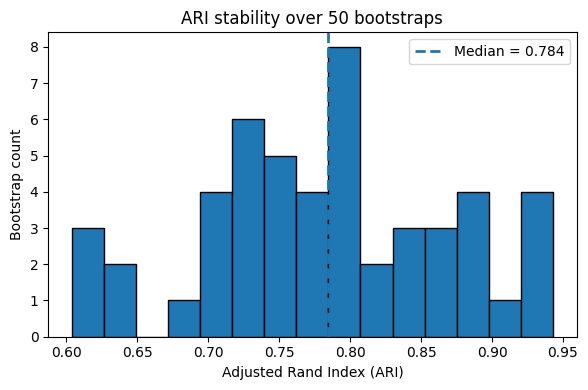

In [ ]:
# === ARI stability plot ===
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(ari_scores, bins=15, edgecolor="black")
plt.axvline(median_ari, linestyle="--", linewidth=2, label=f"Median = {median_ari:.3f}")

plt.xlabel("Adjusted Rand Index (ARI)")
plt.ylabel("Bootstrap count")
plt.title(f"ARI stability over {n_boots} bootstraps")
plt.legend()
plt.tight_layout()
plt.show()

# UMAP

In [65]:
def drop_low_degree_nodes_with_labels(A: csr_matrix, labels, n_neighbors: int):
    """
    A: square CSR matrix (e.g., kNN adjacency)
    labels: 1D numpy array of cluster labels or any node-level annotation
    n_neighbors: minimum required neighbors

    Returns:
        A_filtered  -- CSR matrix with only valid nodes
        labels_filt -- labels for kept nodes
        keep_idx    -- indices of nodes kept from original
    """

    # Count neighbors per node
    row_nnz = A.getnnz(axis=1)

    # Mask for nodes with enough neighbors
    keep_mask = row_nnz >= n_neighbors
    keep_idx = np.where(keep_mask)[0]
    
    print(keep_idx)

    # Filter adjacency matrix
    A_filtered = A[keep_idx][:, keep_idx].tocsr()

    # Filter labels
    labels_filtered = labels[keep_idx]

    return A_filtered, labels_filtered, keep_idx


In [66]:
sim_mat_clean, labels_clean,keep_idx = drop_low_degree_nodes_with_labels(sim_mat,labels, 200)

[    0     1     2 ... 21985 21986 21987]


In [67]:
# A = symmetric_sim_clean
# row_nnz = A.indptr[1:] - A.indptr[:-1]
# print(row_nnz)
# print(min(row_nnz))

In [68]:
def sim_to_diffusion_distance_csr(S: csr_matrix, sigma: float, eps: float = 1e-15):
    """
    Invert a Gaussian kernel on a sparse similarity matrix.

    Parameters
    ----------
    S : csr_matrix
        Sparse similarity matrix with entries in (0, 1].
    sigma : float
        The same sigma used in exp(-d^2 / (2*sigma^2)).
    eps : float
        Lower clip to avoid log(0).

    Returns
    -------
    D : csr_matrix
        Sparse diffusion distance matrix on the same sparsity pattern.
        Nonzeros are D_ij; zeros mean "no distance stored" (not necessarily 0).
    """
    S = S.tocsr().copy()

    # Clip similarities to (eps, 1] to avoid log(0) and any tiny numerical >1
    s_data = np.clip(S.data, eps, 1.0)

    # Invert the Gaussian: d = sqrt(-2 * sigma^2 * log(s))
    D_data = np.sqrt(-2.0 * (sigma ** 2) * np.log(s_data))

    S.data = D_data
    return S


In [69]:
# Transform sim to dist
diff_dist = sim_to_diffusion_distance_csr(sim_mat_clean,sigma = median)

In [70]:
diff_dist.mean()

4.615591734563263e-06

In [73]:
ddm.mean()

6.377462707801046e-06

In [74]:
labels_clean

array([7, 7, 7, ..., 0, 0, 0])

In [75]:
from collections import Counter

def collapse_labels_top_k(labels, k=15, other_label=-1):
    """
    Keep only the top-k most frequent labels.
    All other labels are replaced by `other_label`.

    labels: 1D array-like of ints
    k: number of most frequent labels to keep
    other_label: label assigned to all collapsed groups

    Returns:
        labels_new -- collapsed label array
        keep_map   -- mapping of kept labels to themselves
        top_labels -- list of top-k labels
    """
    labels = np.asarray(labels)

    # Count frequencies
    freq = Counter(labels)

    # Top-k labels by frequency
    top_labels = [lbl for lbl, _ in freq.most_common(k)]

    # Build new labels array
    labels_new = np.array([
        lbl if lbl in top_labels else other_label
        for lbl in labels
    ])

    return labels_new, top_labels


In [76]:
labels_collapsed, top15 = collapse_labels_top_k(labels_clean, k=15, other_label=-1)

print("Top 15 labels:", top15)
print("Unique labels after collapsing:", np.unique(labels_collapsed))

Top 15 labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Unique labels after collapsing: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


c:\Users\celem\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\celem\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


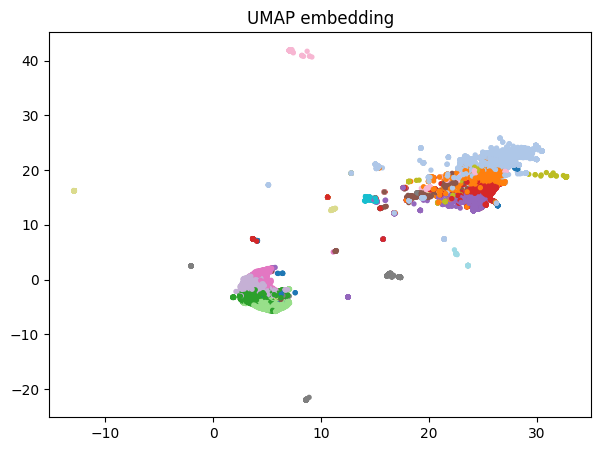

In [77]:
import umap
embedding = umap.UMAP(metric='precomputed', n_neighbors=190).fit_transform(diff_dist)

plt.figure(figsize=(7,5))
plt.scatter(
    embedding[:,0],
    embedding[:,1],
    c=labels_collapsed,
    cmap="tab20",
    s=8
)
plt.title("UMAP embedding")
plt.show()
